# Capsule V1 Tiny

This implementation doesn't have the decoder structure.

> Dynamic Routing Between Capsules. [arXiv:1710.09829v1](https://arxiv.org/abs/1710.09829)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from torchvision import datasets

## Load MINST Data

- download mnist dataset
    - [http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz)
    - [http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz](http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz)
- extract them to a directory

In [2]:
trainImage = datasets.mnist.read_image_file('../Dataset/MNIST/train-images.idx3-ubyte')
trainLabel = datasets.mnist.read_label_file('../Dataset/MNIST/train-labels.idx1-ubyte')
trainImage = trainImage.float() / 255
trainLabel = trainLabel.reshape(-1,1)

N,W,H = trainImage.shape
trainImage = torch.reshape(trainImage, (N,1,W,H))
print(trainImage.shape)
del N,W,H

torch.Size([60000, 1, 28, 28])


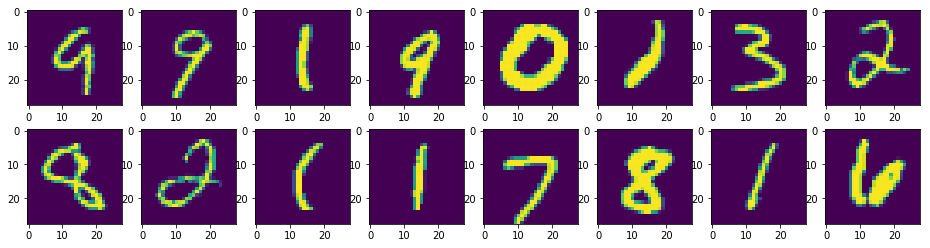

In [3]:
tinp = np.random.choice(trainImage.shape[0], (16,))
tinp = trainImage.data.numpy()[tinp]
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(tinp[i,0])
plt.show()

## Capsule 

- low-layer capsule $\rightarrow$ hight-layer 
- 

### Squashing 

$$
\begin{array}{cc}
v_j = \dfrac{\|s_j\|^2}{1 + \|s_j\|^2} \dfrac{s_j}{\|s_j\|},&
\|s_j\| = \sqrt{\|s_j\|^2_F}
\end{array}
$$

In [4]:
def squashing(s):
    """
    Input:
    - s: (batch, atoms, output_dim)
    Return:
    - v
    """
    vec_squ = torch.sum(s * s, 2, keepdim=True)
    vec_sum = torch.sqrt(vec_squ)
    vec_v = (s * vec_sum) / (1 + vec_squ)
    return vec_v

### Routing algorithm

$$s_j = \sum_i c_{ij} \hat{u}_{j|i}, \quad \hat{u}_{j|i} = W_{ij} u_i$$

$$c_{ij} = \dfrac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}$$

In [5]:
def routing(priors, output_dim, iteration=3):
    """
    batch, input_dim, output_dim, output_atoms
    Input:
    - hatu: (batch, input_dim, atoms) $w \cdot u$
    - nextlayer: a number 
    - iteration: usually 3
    """
    logits = torch.zeros(*priors.shape)
    for i in range(iteration-1):
        probs = F.softmax(logits, dim=2)
        outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
        delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
        logits = logits + delta_logits
    probs = F.softmax(logits, dim=2)
    outputs = squashing((probs * priors).sum(dim=2, keepdim=True))
    return outputs

### Capsule Model

In [18]:
class CapsuleModule(nn.Module):
    def __init__(self):
        super(CapsuleModule, self).__init__()
        self.conv1 = nn.Conv2d(1,32, (9,9), stride=1)
        self.primary_capsule = nn.Conv2d(32, 4*8, (9,9), stride=2, groups=4)

        # num_capsules, 1, num_route_nodes, in_channels, out_channels
        self.w = Parameter(torch.Tensor(10, 1, 4*6*6, 8, 8).normal_())
        
    def forward(self, x):
        """
        Output:
            [batch, output_dim, output_atoms]
        """
        out = F.leaky_relu(self.conv1(x), 0.02) # first layer
        # out (batch,32,6,6)
        out = self.primary_capsule(out) # primary capsule  
        out = torch.transpose(out.view(1, -1, 8, 4*6*6, 1), 2,3)
        priors = torch.sum(out * self.w, dim=3)
        out = routing(priors, 10, 3).squeeze().transpose(0,1)
        classes = torch.sqrt((out * out).sum(dim=-1))
        classes = F.softmax(classes, dim=-1)
        return classes

### Margin Loss

$$L_c = T_c \max(0,m^+ - \|v_c\|)^2 + \lambda (1 - T_c) \max(0, \|v_c\| - m^-)^2$$

In [19]:
def margin_loss(classes, target, mplus=0.9, mminus=0.1, l=0.5):
    """
    - vc: module output, (N,L,J)
    - target: one hot label
    - mplus: $m^+$
    - mminus: $m^-$
    - l: $lambda$
    """
    thezero = torch.zeros_like(classes)
    Lc1 = torch.where(mplus > classes, mplus-classes, thezero)
    Lc2 = torch.where(mminus < classes, classes-mminus, thezero)
    Lc = target * (Lc1*Lc1) + l*(1.0-target)*(Lc2*Lc2)
    return torch.mean(Lc)

### Train

In [20]:
capsule = CapsuleModule()
optim = torch.optim.Adam(capsule.parameters(), lr=1e-2)

In [21]:
# 60000 images
for i in range(0,50000,500):
    tImage = trainImage[i:i+500]
    tLabel = torch.zeros(500, 10).scatter_(1, trainLabel[i:i+500], 1)
    optim.zero_grad()
    classes = capsule(tImage)
    loss = margin_loss(classes, tLabel)
    loss.backward()
    optim.step()
    if i % 2000 == 0:
        print("offset {:05d}, loss {:.8f}".format(i, loss))

offset 00000, loss 0.06400385
offset 02000, loss 0.05877112
offset 04000, loss 0.04890063
offset 06000, loss 0.04345290
offset 08000, loss 0.03478120
offset 10000, loss 0.03062857
offset 12000, loss 0.02824106
offset 14000, loss 0.02760237
offset 16000, loss 0.02105987
offset 18000, loss 0.01826883
offset 20000, loss 0.01758327
offset 22000, loss 0.01683989
offset 24000, loss 0.01687297
offset 26000, loss 0.01486851
offset 28000, loss 0.01490840
offset 30000, loss 0.01405214
offset 32000, loss 0.01643979
offset 34000, loss 0.01306902
offset 36000, loss 0.01301917
offset 38000, loss 0.01231681
offset 40000, loss 0.01317632
offset 42000, loss 0.01410828
offset 44000, loss 0.01402120
offset 46000, loss 0.01480285
offset 48000, loss 0.01158743


### test output

In [22]:
tout = capsule(trainImage[50000:50000+200])
capout = torch.argmax(tout,dim=1)
print(capout)

tensor([3, 8, 6, 9, 6, 9, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7,
        8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5,
        0, 6, 8, 7, 6, 8, 3, 9, 4, 0, 6, 1, 9, 2, 8, 3, 9, 4, 4, 5, 6, 6, 1, 7,
        2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9,
        4, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7,
        9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2,
        6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8,
        0, 6, 1, 3, 2, 0, 8, 6])


In [23]:
actlabel = trainLabel[50000:50000+200,0]
print(actlabel)

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7,
        8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1, 7, 2, 7, 3, 1, 4, 0, 5,
        0, 6, 8, 7, 6, 8, 9, 9, 4, 0, 6, 1, 9, 2, 6, 3, 9, 4, 4, 5, 6, 6, 1, 7,
        2, 8, 6, 9, 7, 0, 9, 1, 6, 2, 8, 3, 6, 4, 9, 5, 8, 6, 8, 7, 8, 8, 6, 9,
        1, 7, 6, 0, 9, 6, 7, 0, 9, 7, 1, 3, 6, 8, 4, 6, 1, 7, 5, 1, 3, 3, 5, 7,
        9, 9, 6, 7, 3, 4, 1, 0, 4, 2, 4, 5, 0, 0, 1, 6, 6, 4, 7, 9, 4, 6, 5, 2,
        6, 9, 8, 8, 8, 5, 9, 3, 8, 9, 8, 8, 8, 3, 4, 4, 3, 0, 9, 5, 4, 4, 1, 8,
        0, 6, 1, 3, 2, 0, 8, 6])


In [26]:
print(torch.sum(capout == actlabel).float() / 200)

tensor(0.9800)
